In [17]:
#!pip install stocktrends

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from stocktrends import Renko

In [5]:
df = pd.read_csv(r'..\data\nq-aug-1-to-aug-15-2024-for-renko-ipynb-l.txt')

In [3]:
# Create a column called date comibing Date and Time
df['date'] = pd.to_datetime(df.Date + ' ' + df.Time)


In [4]:
# drop Date and Time
df = df.drop(['Date', 'Time'], axis=1)

In [5]:
# Function to convert ohlc data into renko bricks. Pass dataframe name and brick size
def df_to_renko(data, n):
    data.reset_index(inplace=True)
    data.columns = [i.lower() for i in data.columns]
    print(data.isnull().values.any())
    df = Renko(data)
    df.brick_size = n
    renko_df = df.get_ohlc_data()
    return renko_df

In [6]:
r_bars = df_to_renko(df, 50)
print('# of rows in DF:',len(r_bars))

False
# of rows in DF: 296


In [7]:
r_bars.head()

,date,open,high,low,close,uptrend
0,2024-07-31 18:00:05,19500.0,19550.0,19500.0,19550.0,True
1,2024-07-31 18:01:20,19550.0,19600.0,19550.0,19600.0,True
2,2024-07-31 19:14:15,19600.0,19650.0,19600.0,19650.0,True
3,2024-07-31 20:12:20,19650.0,19700.0,19650.0,19700.0,True
4,2024-08-01 02:58:25,19650.0,19650.0,19600.0,19600.0,False


In [8]:
# Takes just the open and close columns from the Renko open/high/low/close dataframe
new_df = r_bars[['open','close']]

In [9]:
plt.rcParams["figure.figsize"] = (18,9)

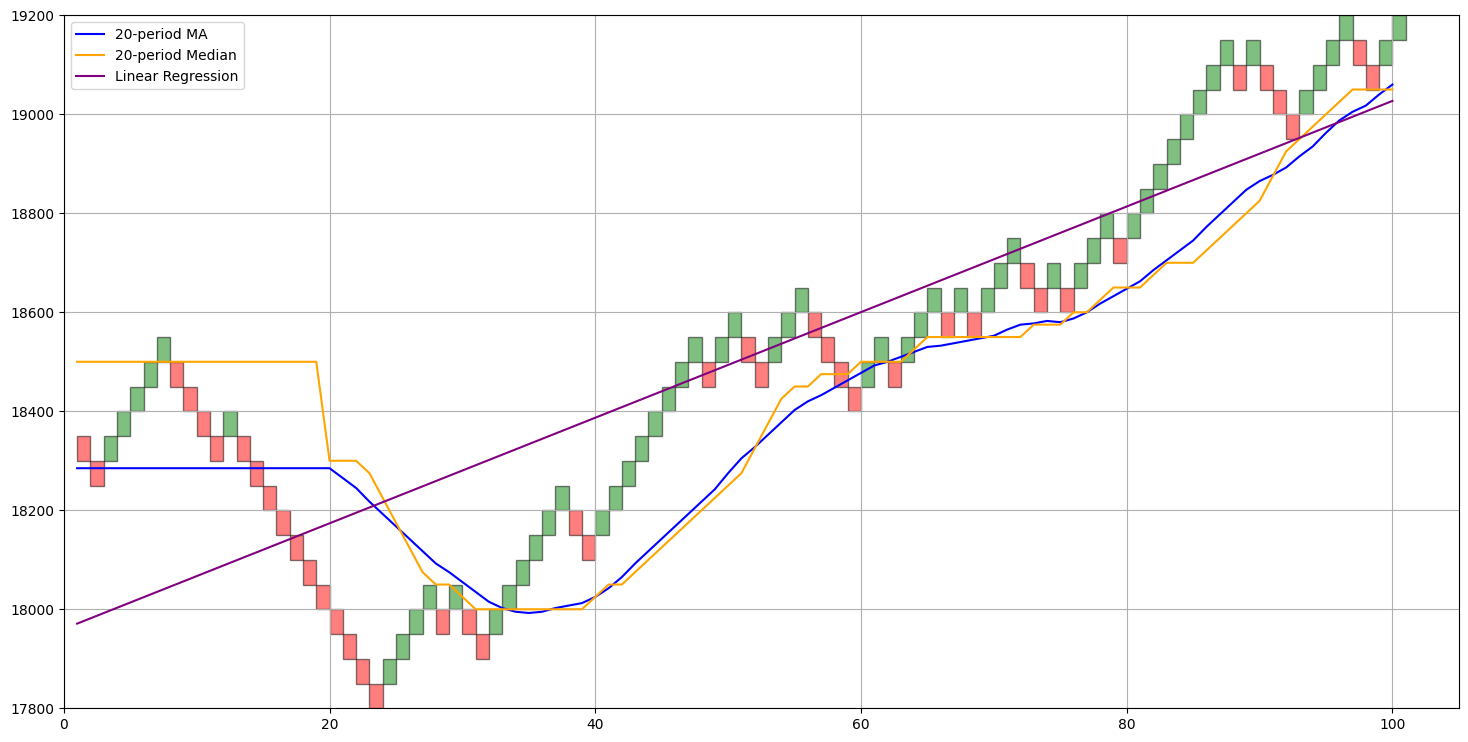

In [10]:
# Create the figure
fig = plt.figure(1)
fig.clf()
axes = fig.gca()

# Add 10 extra spaces to the right
num_bars = 100
df = new_df.tail(num_bars).copy()  # Copy to avoid modifying the original DataFrame

# Ensure 'close' is numeric and drop any rows with NaN values to prevent errors in calculations
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df.dropna(subset=['close'], inplace=True)

# Calculate a 20-period moving average of the close prices
df.loc[:, 'MA20'] = df['close'].rolling(window=20).mean()

# Forward fill the NaN values at the beginning of the MA20 to extend the line to the start
df.loc[:, 'MA20'] = df['MA20'].fillna(df['MA20'].iloc[19])

# Calculate a 20-period rolling median of the close prices
df.loc[:, 'Median20'] = df['close'].rolling(window=20).median().fillna(df['close'].median())

# Calculate linear regression on the close prices
x = np.arange(len(df))
y = df['close'].values
slope, intercept = np.polyfit(x, y, 1)
df.loc[:, 'LinearRegression'] = slope * x + intercept

renkos = zip(df.index, df['open'], df['close'])
# Plot the bars, green for 'up', red for 'down'
index = 1

for idx, open_price, close_price in renkos:
    if open_price < close_price:
        renko = matplotlib.patches.Rectangle((index, open_price), 1, close_price - open_price, edgecolor='black', facecolor='green', alpha=0.5)
        axes.add_patch(renko)
    else:
        renko = matplotlib.patches.Rectangle((index, open_price), 1, close_price - open_price, edgecolor='black', facecolor='red', alpha=0.5)
        axes.add_patch(renko)
    index = index + 1

# Plot the moving average, median, and linear regression lines
axes.plot(range(1, num_bars + 1), df['MA20'], color='blue', label='20-period MA')
axes.plot(range(1, num_bars + 1), df['Median20'], color='orange', label='20-period Median')
axes.plot(range(1, num_bars + 1), df['LinearRegression'], color='purple', label='Linear Regression')

# Adjust the axes
plt.xlim([0, num_bars + 5])
plt.ylim([min(min(df['open']), min(df['close'])), max(max(df['open']), max(df['close']))])

plt.grid(True)
plt.legend()
plt.show()